In [22]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import hiddenlayer as hl
from tqdm.notebook import tqdm
from tqdm import tnrange
import pdb
from time import time
t1 = time()
device = torch.device("cuda")

# 参数设置

In [23]:
A1_list = [0.6]
delta1_list = [0.2]
delta2_list = [8]
para_list = [[a1, d1, d2] for a1 in A1_list for d1 in delta1_list
             for d2 in delta2_list]
batch_size = 32
lr = 0.001
wd = 0.0000  #
dropout = 0.  #
epoch = 200
flowlen = 12  # 输入长度
in_size = 1  # 输入通道
hid_size = 256
num_layers = 1
pred_size = 1  # 输出长度
ch = 1  # 同in_size

save_path = "tflow.pth"

# 反归一化

In [24]:
def InvNorm(tensor, d_1, d_2):
    dminT = torch.tensor(d_1).to(tensor.device)
    dmaxT = torch.tensor(d_2).to(tensor.device)
    return tensor * (dmaxT - dminT) + dminT
# def InvNorm(tensor, d_1, d_2):
#     """
#     反归一化
#     """
#     dstdT = torch.tensor(d_1).to(tensor.device)
#     dmeanT = torch.tensor(d_2).to(tensor.device)
#     return tensor * dstdT + dmeanT

# 性能指标

In [25]:
class AverageValueMeter():
    def __init__(self):
        self.N=0
        self.ave=0
    
    def add(self,x):
        self.ave=self.N/(1+self.N)*self.ave+1/(1+self.N)*x
        self.N+=1
    
    def reset(self):
        self.N=0
        self.ave=0
    
    def value(self):
        return self.ave,self.N

In [26]:
def metric(real_output, pred_output, d_1, d_2):
    '''
    :param real_output:
    :param pred_output:
    :return:
    '''
    pred_output = InvNorm(pred_output, d_1, d_2).detach().cpu().numpy()
    real_output = InvNorm(real_output, d_1, d_2).detach().cpu().numpy()
    D_values = real_output - pred_output
    n_samples = len(real_output)
    D_values_square = np.square(D_values)
    MSE = np.sum(D_values_square) / n_samples
    RMSE = np.sqrt(MSE)
    absoluted_D_values = np.absolute(D_values)
    mape_list = []
    for i in range(len(D_values)):
        pred_real_divide = absoluted_D_values[i] / real_output[i]
        mape_list.append(pred_real_divide)
    MAPE = np.sum(mape_list) / n_samples
    return RMSE, MAPE

In [27]:
def rmse(preds, labels, d_1, d_2, isNorm=True):
    if isNorm:
        preds = InvNorm(preds, d_1, d_2)
        labels = InvNorm(labels, d_1, d_2)
    loss = nn.MSELoss()(preds, labels)
    RMSE = np.sqrt(loss.item())
    return RMSE

In [28]:
def mape(preds, labels, d_1, d_2, isNorm=True):
    if isNorm:
        preds = InvNorm(preds, d_1, d_2)
        labels = InvNorm(labels, d_1, d_2)
    preds = preds.flatten().detach().cpu().numpy()
    labels = labels.flatten().detach().cpu().numpy()
    mask = labels != 0
    return np.fabs((labels[mask] - preds[mask]) / labels[mask]).mean()

# 加载数据

In [29]:
ori_data = loadmat("corrected_data.mat")
# 确定使用哪条道路的数据
stack_data = np.hstack([
     ori_data["A1_10min"],
#     ori_data["A2_10min"],
#     ori_data["A4_10min"],
#     ori_data["A8_10min"],
])
print(stack_data.shape)
# plt.plot(stack_data[0])
# 最大最小归一化
d_1 = stack_data.min()
d_2 = stack_data.max()
stack_data = (stack_data - d_1) / (d_2 - d_1)
# 高斯归一化
# d_1 = np.std(stack_data, axis=0)
# d_2 = np.mean(stack_data, axis=0)
# stack_data = (stack_data - d_2) / d_1

# 训练：测试=8：2
trainD, testD = stack_data[:int(stack_data.shape[0] *
                                0.8), :], stack_data[int(stack_data.shape[0] *
                                                          0.8):, :]
print(trainD.shape, testD.shape)

(5040, 1)
(4032, 1) (1008, 1)


# 数据集

In [ ]:
class TFDataset(torch.utils.data.Dataset):
    def __init__(self, in_num, out_num, dataset):
        super().__init__()
        self.in_num = in_num
        self.out_num = out_num
        self.dataset = dataset

    def __getitem__(self, index):
        index += 1
        in_item = self.dataset[index:index + self.in_num, :]
        out_item = self.dataset[index + self.in_num:index + self.in_num +
                                self.out_num, :]
        dec_inp = np.copy(self.dataset[index - 1:index + self.in_num - 1, :])
        # 初始化解码器的第一个输入
        dec_inp[0, :] = 0.5
        return in_item, out_item, dec_inp

    def __len__(self):
        return self.dataset.shape[0] - self.in_num - self.out_num - 1

(12, 1) (1, 1) (12, 1)


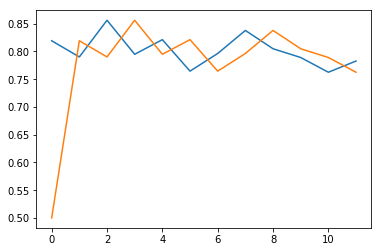

In [ ]:
# 看看数据集输出是否符合预期
d=TFDataset(12,1,trainD)
a=iter(d)
b=next(a)
print(b[0].shape,b[1].shape,b[2].shape)
plt.plot(b[0])
plt.plot(b[2])

# 重构网络

## Seq2Seq+Attention

* 参考网址 https://zhuanlan.zhihu.com/p/135970560 的option2

In [ ]:
class S2SnetAtt(nn.Module):
    def __init__(
        self,
        flowlen,
        in_size,
        hid_size,
        num_layers,
    ):
        super().__init__()
        self.flowlen = flowlen
        self.in_size = in_size
        self.hid_size = hid_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=self.in_size,
            hidden_size=self.hid_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.decoder = nn.LSTM(
            input_size=self.in_size + self.hid_size,
            hidden_size=self.hid_size,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.Wk = nn.Parameter(torch.rand((hid_size, hid_size)))
        self.Wq = nn.Parameter(torch.rand((hid_size, hid_size)))
        self.fc = nn.Linear(hid_size * flowlen, flowlen, bias=True)

    def forward(self, enc_x, dec_x):
        bs, le, ch = enc_x.shape
        enc_o, last_hid, ct = self.encoder_forward(enc_x)
        # atn
        out = self.decoder_forward(enc_o, last_hid, ct, dec_x)
        out_fc = self.fc(out.reshape(bs, -1)).reshape(bs, le, ch)
        return out_fc

    def encoder_forward(self, x):
        enc_o, (h, c) = self.encoder(x)
        # torch.Size([20, 12, 256]) torch.Size([2, 20, 256]) torch.Size([2, 20, 256])
        return enc_o, h, c

    def attention_forward(self, enc_o, last_hid):
        bs = enc_o.shape[0]
        S0 = last_hid[-1].unsqueeze(1)  # [20,1,256]
        hi = enc_o  # [20,12,256]
        ki = torch.bmm(hi, self.Wk.expand(bs, self.hid_size,
                                          self.hid_size))  # [20,12,256]
        qt = torch.bmm(S0, self.Wq.expand(bs, self.hid_size,
                                          self.hid_size))  # [20,1,256]
        qt = qt.permute(0, 2, 1)  # [20,256,1]
        alpha = torch.bmm(ki, qt)  # [20,12,1]
        alpha = torch.softmax(alpha, dim=1)  # [20,12,1]
        context = torch.sum(alpha * enc_o, dim=1)  # [20,256]
        return context

    def decoder_forward(self, enc_o, last_hid, c, dec_x=None, dec_size=None):
        if dec_x is not None:
            # 每时刻解码器的输入为上一刻标签
            bs, le, ch = dec_x.shape  # [20,12,1]
            out_list = list()
            for i in range(le):
                context = self.attention_forward(enc_o, last_hid)
                context = context.unsqueeze(1)  # [20,256]->[20,1,256]
                dec_inp = torch.cat([dec_x[:, i, :].unsqueeze(1), context],
                                    dim=2)  # [20,1,1+ 256]
                out, (last_hid, c) = self.decoder(dec_inp, (last_hid, c))
                out_list.append(out)
            out = torch.cat(out_list, dim=1)# [20,12,256]
        else:
            # 每时刻解码器的输入为上一刻编码器的输出
            pass
        return out

## seq2seq重构
* 点1到12 输入 编码器，输出 ht，ct
* 点0和1到11 以及ht，ct输入 解码器，重构点1到12

In [ ]:
class S2Snet(nn.Module):
    def __init__(
        self,
        flowlen,
        in_size,
        hid_size,
        num_layers,
    ):
        super().__init__()
        self.flowlen = flowlen
        self.in_size = in_size
        self.hid_size = hid_size
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=self.in_size,
            hidden_size=self.hid_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.decoder = nn.LSTM(
            input_size=self.in_size,
            hidden_size=self.hid_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hid_size * flowlen, flowlen, bias=True)

    def forward(self, enc_x, dec_x):
        bs, le, ch = enc_x.shape
        context = self.encoder_forward(enc_x)
        out = self.decoder_forward(context, dec_x)
        out_fc = self.fc(out.reshape(bs, -1)).reshape(bs, le , ch)
#         print(context[0].shape, context[1].shape, out.shape, out_fc.shape)
        return out_fc

    def encoder_forward(self, x):
        _, hc = self.encoder(x)
        return hc

    def decoder_forward(self, context, dec_x=None, dec_size=None):
        if dec_x is not None:
            # 每时刻解码器的输入为上一刻标签
            out, _ = self.decoder(dec_x, context)
        else:
            # 每时刻解码器的输入为上一刻编码器的输出
            pass
        return out

## 卷积自编码器

In [ ]:
class CAE(nn.Module):
    def __init__(self, flowlen):
        super().__init__()
        self.flowlen = flowlen
        self.conv = nn.Sequential(
            nn.Conv1d(flowlen, 64, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
            nn.Conv1d(128, self.flowlen, kernel_size=3, stride=1, padding=1),
        )
        self.fc = nn.Sequential(
            nn.Linear(self.flowlen, 64, bias=True),
            nn.Sigmoid(),
            nn.Linear(64, self.flowlen, bias=False),
        )

    def forward(self, x):
        bs,le,ch=x.shape
        x = x.reshape(bs,-1)
        out=self.fc(x)
        out=out.reshape(bs,le,ch)
        return out

# 预测网络

## LSTM+Attention 预测

* https://www.cnblogs.com/cxq1126/p/13504437.html
* 形式一

In [ ]:
class LstmAttNet(nn.Module):
    def __init__(self, in_size, hid_size, num_layers, out_size, dropout=0):
        super().__init__()
        self.in_size = in_size
        self.hid_size = hid_size
        self.num_layers = num_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(
            input_size=self.in_size,
            hidden_size=self.hid_size,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.Dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(in_features=self.hid_size,
                                out_features=self.out_size)

    def attention_forward(self, lstm_out, query):
        """
        lstm_out# [20,12,256]
        query# [20,12,256]
        """
        d_k = query.shape[-1]
        scores = torch.bmm(query, lstm_out.permute(0, 2, 1)) / np.sqrt(
            d_k)  # [20,12,12]
        p_attn = torch.softmax(scores, dim=2)  # [20,12,12]
        context = torch.bmm(p_attn, lstm_out)  # [20,12,256]
        context = torch.sum(context, dim=1)  # [20,256]
        return context, p_attn

    def forward(self, x):
        bs,le,ch=x.shape
        out, (h, c) = self.lstm(x)
        # 两种不同的方式：
        # 1.
        # query=self.Dropout(out)
        # 2.
        query=h[-1].unsqueeze(1).repeat(1,le,1)
        
        context, _ = self.attention_forward(out, query)
        # 取最后一刻的输出，reshape成原本的样子
        out = self.linear(context).reshape((x.shape[0], -1, self.in_size))
        return out


## LSTM

In [ ]:
class LstmNet(nn.Module):
    def __init__(self, in_size, hid_size, num_layers, out_size, dropout=0):
        super().__init__()
        self.in_size = in_size
        self.hid_size = hid_size
        self.num_layers = num_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(
                input_size=self.in_size,
                hidden_size=self.hid_size,
                num_layers=self.num_layers,
                batch_first=True,
            )
        self.Dropout=nn.Dropout(dropout)
        self.linear = nn.Linear(in_features=self.hid_size,
                                out_features=self.out_size)

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        #  取最后一刻的输出，reshape成原本的样子
        out = self.linear(self.Dropout(out[:, -1, :])).reshape(
            (x.shape[0], -1, self.in_size))
        return out

# 训练

## 训练准备

In [ ]:
train_ds = TFDataset(flowlen, pred_size, trainD)
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=0,
                                       drop_last=False)
test_ds = TFDataset(flowlen, pred_size, testD)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=testD.shape[0],
                                      shuffle=False,
                                      num_workers=0,
                                      drop_last=False)
MSELoss = nn.MSELoss()
CELoss = nn.CrossEntropyLoss()

## 训练循环

In [ ]:
for A1, delta1, delta2 in para_list:
    print("A1:{0},delta1:{1},delta2:{2}".format(A1, delta1, delta2))
    tfae = S2SnetAtt(flowlen, in_size, hid_size, num_layers).to(device)

    tfnet = LstmNet(in_size, hid_size, num_layers, pred_size * in_size,
                    dropout).to(device)

    tfopae = torch.optim.Adam(tfae.parameters(), lr=lr, weight_decay=wd)
    tfop = torch.optim.Adam(tfnet.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(tfop, step_size=100, gamma=0.1)
    schedulerae = torch.optim.lr_scheduler.StepLR(tfopae,
                                                  step_size=100,
                                                  gamma=0.1)
    scheduler.last_epoch = 0

    his = hl.History()
    cav = hl.Canvas()
    best_loss = 9999
    loss_avg = AverageValueMeter()
    aeloss_avg = AverageValueMeter()
    mseloss_avg = AverageValueMeter()
    RMSE = 0
    MAPE = 0
    ifae = False  # 是否使用自编码器进行重建
    pbar = tqdm(range(epoch))  # 训练进度指示器
    for e in pbar:
        pbar.set_description(desc="R %.3f M %.6f" % (RMSE, MAPE))
        loss_avg.reset()
        aeloss_avg.reset()
        mseloss_avg.reset()
        tfae.train()
        tfnet.train()
        for i, (inp, future, dec_inp) in enumerate(train_dl):
            inp = inp.float().to(device)
            future = future.float().to(device)
            dec_inp = dec_inp.float().to(device)
            # 重构
            if ifae:
                outae = tfae(inp, dec_inp)
                out = tfnet(outae)
            # LSTM预测, 把outae换成inp可以训练LSTM直接接受标签输入
            else:
                out = tfnet(inp)

            # 损失函数
            if ifae:
                aeloss = MSELoss(outae.detach(), inp)
            mseloss = 1. - torch.exp(-0.5 * MSELoss(out, future))
            #mseloss = MSELoss(out, future)
            if ifae:
                loss = mseloss + aeloss
            else:
                loss = mseloss

            if ifae:
                tfopae.zero_grad()
            tfop.zero_grad()
            loss.backward()
            if ifae:
                tfopae.step()
            tfop.step()
            loss_avg.add(loss.item())
            if ifae:
                aeloss_avg.add(aeloss.item())
            mseloss_avg.add(mseloss.item())

        RMSE = rmse(out, future, d_1, d_2)
        MAPE = mape(out, future, d_1, d_2)
        # 记录指标
        his.log(
            e,
            loss=loss_avg.value()[0],
            aeloss=aeloss_avg.value()[0],
            mseloss=mseloss_avg.value()[0],
            RMSE=RMSE,
            MAPE=MAPE,
        )

        testRMSE = 0
        testMAPE = 0
        testAELoss = 0
        testmseloss = 0
        # ptstd = torch.tensor(std).reshape((1, 1, 4)).to(device)
        # ptmean = torch.tensor(mean).reshape((1, 1, 4)).to(device)
        with torch.no_grad():
            tfnet.eval()
            tfae.eval()
            for i, (inp, future, dec_inp) in enumerate(test_dl):
                inp = inp.float().to(device)
                future = future.float().to(device)
                dec_inp = dec_inp.float().to(device)
                if ifae:
                    outae = tfae(inp, dec_inp)
                    out = tfnet(outae)
                else:
                    out = tfnet(inp)
                # 这里应该跟上边训练的损失一致
                testmseloss += MSELoss(out, future).item()
                r, m = metric(future, out, d_1, d_2)
                if ifae:
                    aeloss = MSELoss(outae, inp)
                    testAELoss += aeloss.item()
                testRMSE += r
                testMAPE += m

            testRMSE /= i + 1
            testMAPE /= i + 1
            testmseloss /= i + 1
            testAELoss /= i + 1
            f = open(
                "A1testRMSE-AttLSTM" +
                "_{0}_{1}_{2}".format(A1, delta1, delta2) + ".txt", 'a')
            f.write(str(testRMSE) + '\n')
            f.close()

            his.log(
                e,
                testmseloss=testmseloss,
                testRMSE=testRMSE,
                testMAPE=testMAPE,
            )

        # 根据loss来保存最优模型
        if loss_avg.value()[0] <= best_loss:
            best_loss = loss_avg.value()[0]
            state = {
                'tfnet': tfnet.state_dict(),
                'tfae': tfae.state_dict(),
            }
            torch.save(state, save_path)
        # 步长调整
        scheduler.step()
        if ifae:
            schedulerae.step()
    # 绘制指标
#     with cav:
#         cav.draw_plot([
#             his["loss"],
#             his["aeloss"],
#             his["mseloss"],
#             his["testmseloss"],
#         ])
#         cav.draw_plot([
#             his["RMSE"],
#             his["MAPE"],
#         ])
#         cav.draw_plot([
#             his["testRMSE"],
#             his["testMAPE"],
#         ])

A1:0.6,delta1:0.2,delta2:8


# 测试

In [ ]:
## test_ds = TFDataset(flowlen, pred_size, testD)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=testD.shape[0],
                                      shuffle=False,
                                      num_workers=0,
                                      drop_last=False)
# 注释掉加载则可以使用训练最后一轮的模型权重进行测试
checkpoint = torch.load(save_path)
tfnet.load_state_dict(checkpoint['tfnet'])
tfae.load_state_dict(checkpoint['tfae'])
tfnet.eval()
tfae.eval()
RMSE = 0
MAPE = 0
AELoss = 0
# ptstd = torch.tensor(std).reshape((1, 1, 4)).to(device)
# ptmean = torch.tensor(mean).reshape((1, 1, 4)).to(device)
with torch.no_grad():
    for i, (inp, future, dec_inp) in tqdm(enumerate(test_dl),
                                          total=test_dl.__len__(),
                                          leave=False):
        inp = inp.float().to(device)
        future = future.float().to(device)
        dec_inp = dec_inp.float().to(device)
        if ifae:
            outae = tfae(inp, dec_inp)
            out = tfnet(outae)
        else:
            out = tfnet(inp)
        r, m = metric(future, out, d_1, d_2)
        if ifae:
            aeloss = MSELoss(outae, inp)
            AELoss += aeloss.item()
        RMSE += r
        MAPE += m
            
    RMSE /= i + 1
    MAPE /= i + 1
    AELoss /= i + 1
    print("RMSE {:.4f},MAPE {:.6f},AELoss {:.6f}".format(RMSE, MAPE*100, AELoss))
    print(i)
# bs = 0
# road_ch = 0
# plt.figure(figsize=(4, 4))
# i = inp[bs, :, road_ch].detach().cpu().numpy()
# p = future[bs, :, road_ch].detach().cpu().numpy()
# o = out[bs, :, road_ch].detach().cpu().numpy()
# p = np.concatenate((i, p))
# o = np.concatenate((i, o))
# plt.plot(p, label="future")
# plt.plot(o, label="pred")
# plt.legend(loc='upper right')
t2 = time()
time = t2 - t1
print(f"time:{time}sec")